## Running notebook to test the developed functions

In [1]:
import matplotlib.pyplot as plt
import cv2

from src import preprocessing as pp
from src import contour_detection as cd
from src import symetry_analysis as sa

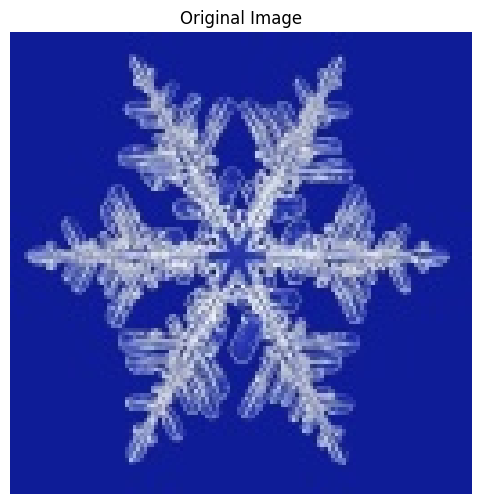

In [2]:
# Path to the uploaded image
image_path = "data/042.jpg"
image = cv2.imread(image_path)


# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

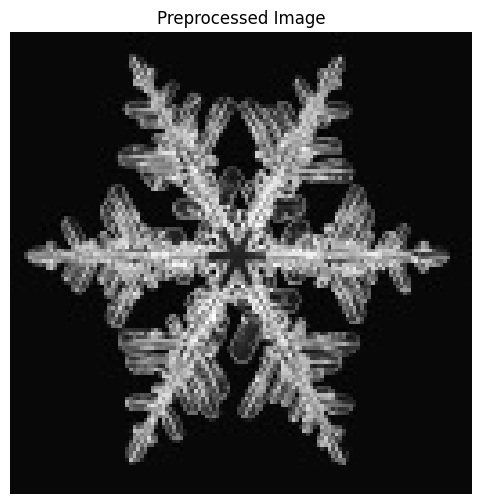

In [3]:

preprocessed_image = pp.preprocess_image(image)

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.title("Preprocessed Image")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

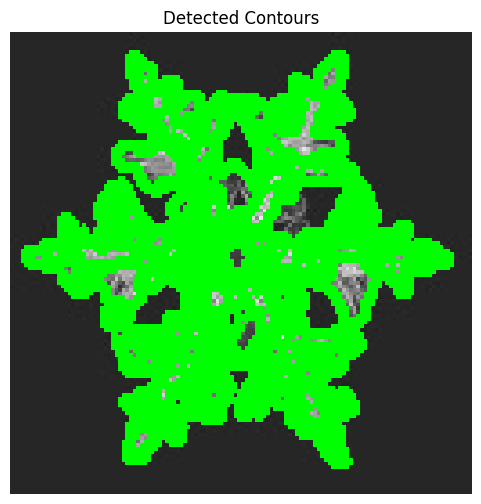

In [4]:
# Assuming preprocessed_image is already generated
contour_image, contours = cd.detect_contours(preprocessed_image)

# Display the contour_image
plt.figure(figsize=(6, 6))
plt.title("Detected Contours")
plt.imshow(contour_image)
plt.axis('off')
plt.show()

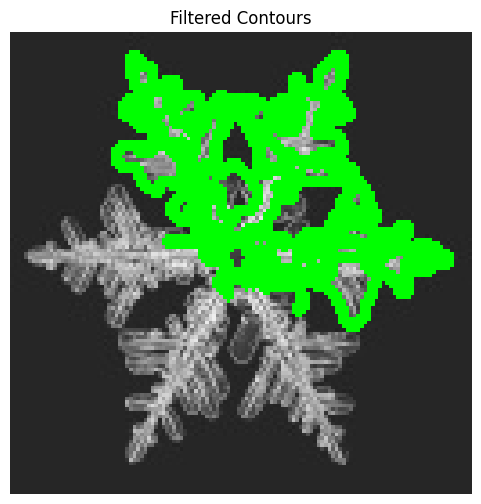

In [5]:
filtered_contour_image, filtered_contours = cd.filter_contours(preprocessed_image, contours, min_area=100, max_area=10000, circularity_threshold=0.01)

plt.figure(figsize=(6, 6))
plt.title("Filtered Contours")
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

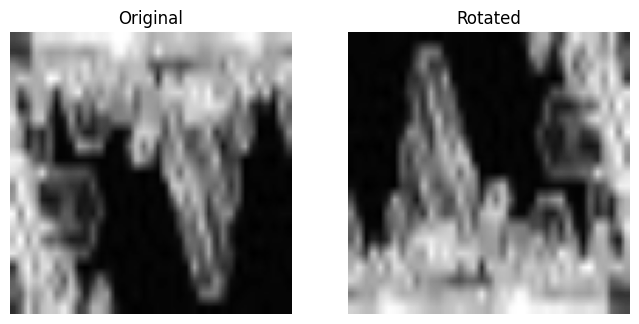

Symmetry Score: 0.06


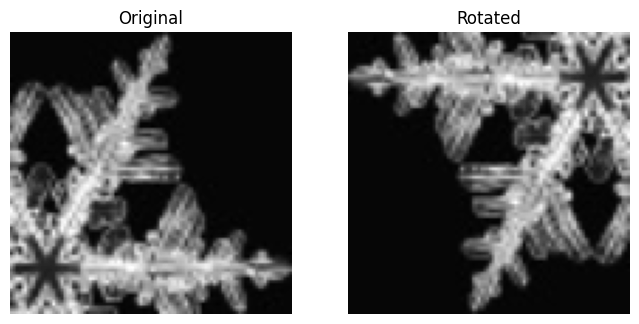

Symmetry Score: 0.05


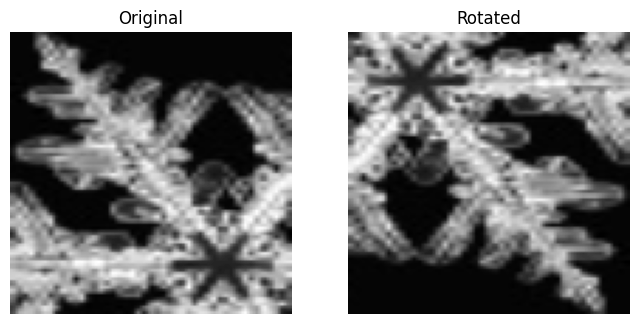

Symmetry Score: 0.06


In [6]:
symmetry_scores = sa.analyze_symmetry(preprocessed_image, filtered_contours)